# Running some other statistics such as regressions with inventory (largest table available!)
 

SELECT   distinct equipment_type,  equipment_string,  equipment_class 
	FROM public.inventory_round_ed

In [14]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [15]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")


print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


Overview of the weapons:

In [16]:
# Query to get all distinct weapons
query_all_weapons = """
SELECT DISTINCT 
    equipment_type,
    equipment_string,
    equipment_class
FROM public.inventory_round_ed
ORDER BY equipment_type
"""

print("Fetching all distinct weapons...")
weapons_df = pd.read_sql_query(query_all_weapons, conn)
print(f"Found {len(weapons_df):,} distinct weapons\n")
print(weapons_df.to_string(index=False))


Fetching all distinct weapons...


C:\Users\peter\AppData\Local\Temp\ipykernel_30292\3903597427.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weapons_df = pd.read_sql_query(query_all_weapons, conn)


Found 43 distinct weapons

 equipment_type   equipment_string  equipment_class
              1              P2000                1
              2           Glock-18                1
              3               P250                1
              4       Desert Eagle                1
              5         Five-SeveN                1
              6      Dual Berettas                1
              7              Tec-9                1
              8          CZ75 Auto                1
              9              USP-S                1
             10        R8 Revolver                1
            101                MP7                2
            102                MP9                2
            103           PP-Bizon                2
            104             MAC-10                2
            105             UMP-45                2
            106                P90                2
            107             MP5-SD                2
            201          Sawed-Off   

In [26]:
# Query to get weapon statistics (appearances when event_type = 1)
query_weapon_stats = """
SELECT 
    lq.equipment_type,
    lq.equipment_string,
    lq.equipment_class,
    case 
        when lq.is_ct_t1 = true and lq.team = 1 then true
        when lq.is_ct_t1 = false and lq.team = 2 then true
        else false
    end as is_ct,
    COUNT(*) as appearance_count,
    ROUND(100.0 * COUNT(DISTINCT lq.round_id) / (SELECT COUNT(DISTINCT round_id) FROM inventory_round_ed WHERE event_type = 1), 2) as percentage_of_rounds,
    ROUND(CAST(COUNT(*) AS numeric) / COUNT(DISTINCT lq.round_id), 4) as avg_per_round
    
    from (
    select 
    ir.equipment_type,
    ir.equipment_string,
    ir.equipment_class,
    ir.round_id,
    re.is_ct_t1,
    pr.team
    FROM public.inventory_round_ed ir
    left JOIN player_round_ed pr ON ir.player_round_id = pr.id
    left join rounds_ed re on ir.round_id = re.id
    WHERE ir.event_type = 1 AND ir.equipment_type != 405
    ) as lq
    

GROUP BY 1,2,3,4
ORDER BY avg_per_round DESC
"""
weapon_stats_df = pd.read_sql_query(query_weapon_stats, conn)
print(f"✅ Loaded statistics for {len(weapon_stats_df):,} weapon types\n")
print(weapon_stats_df.to_string(index=False))

C:\Users\peter\AppData\Local\Temp\ipykernel_30292\1401967952.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weapon_stats_df = pd.read_sql_query(query_weapon_stats, conn)


✅ Loaded statistics for 84 weapon types

 equipment_type   equipment_string  equipment_class  is_ct  appearance_count  percentage_of_rounds  avg_per_round
            505      Smoke Grenade                6   True           9281647                 87.22         4.0903
            505      Smoke Grenade                6  False           9649262                 90.73         4.0881
            504          Flashbang                6  False           9240565                 90.74         3.9145
              2           Glock-18                1  False           9490485                 95.70         3.8121
            504          Flashbang                6   True           8463933                 85.68         3.7973
            502            Molotov                6  False           7504658                 77.94         3.7010
            503 Incendiary Grenade                6   True           6661045                 71.66         3.5729
              9              USP-S             

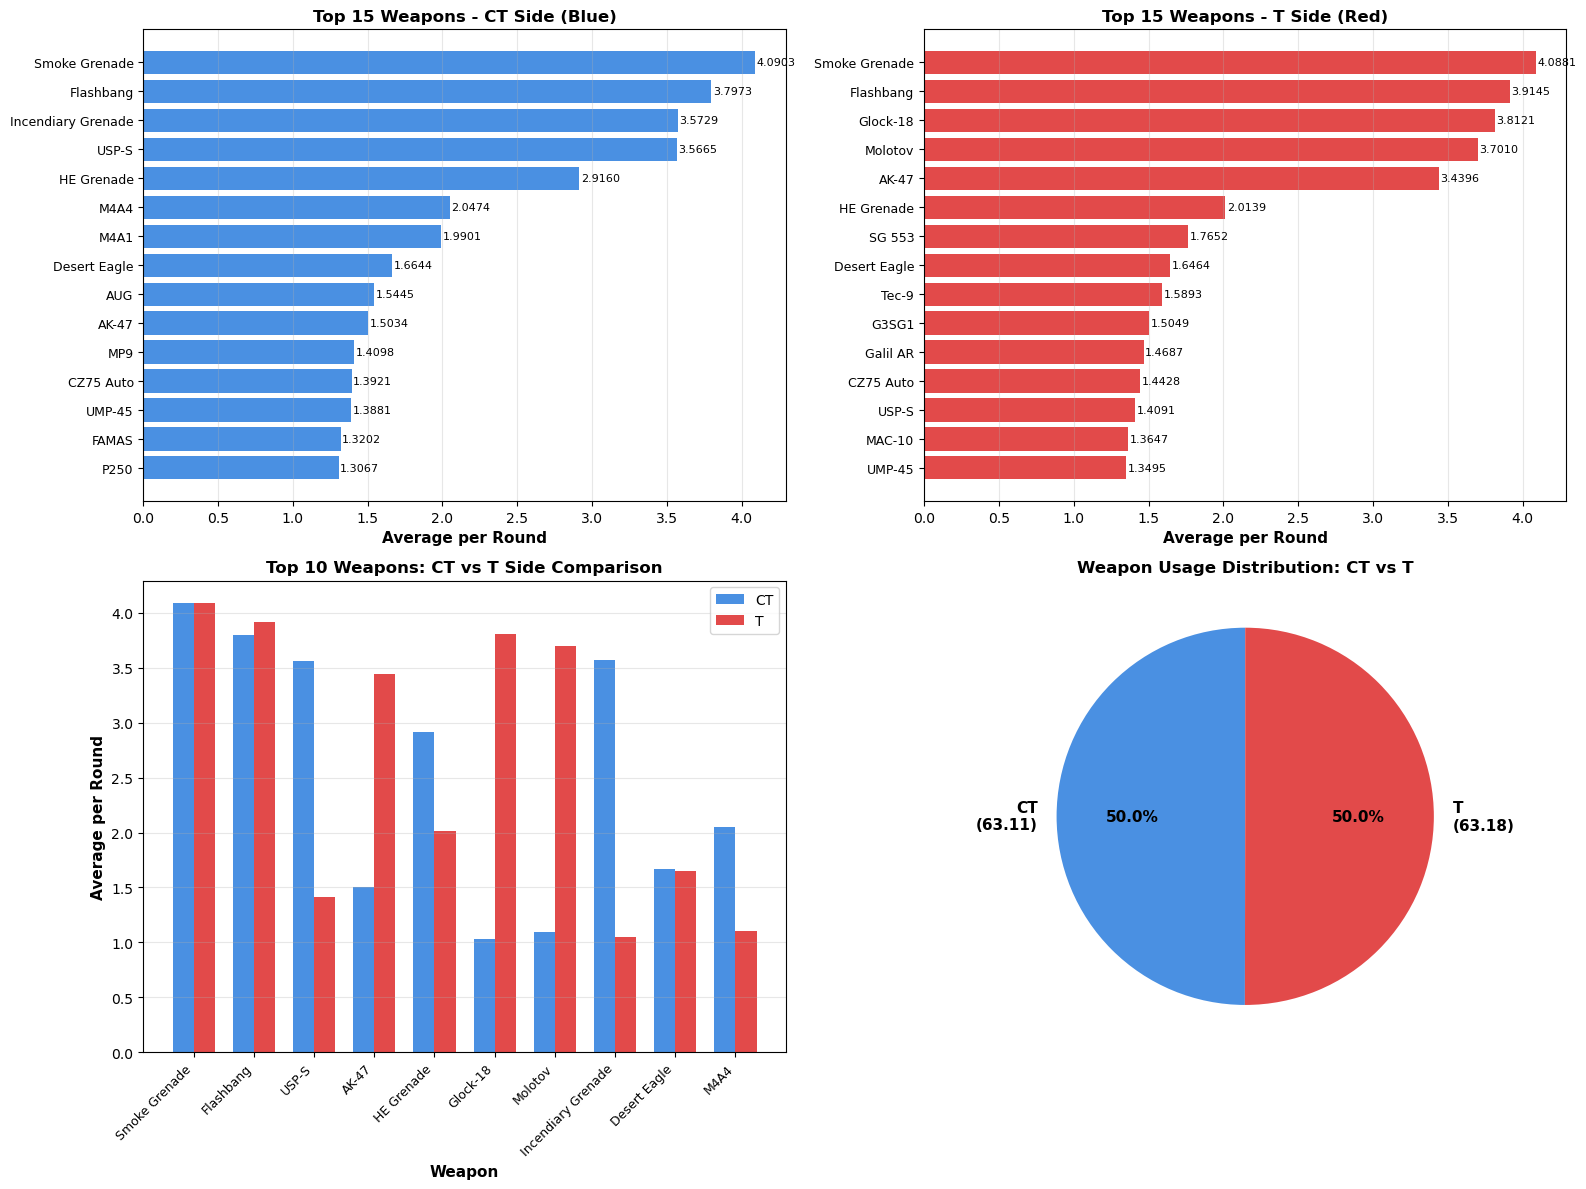

✅ Side comparison visualizations complete!

📊 Summary by Side (Average per Round):
   CT weapons total avg: 63.1085
   T weapons total avg: 63.1809
   CT percentage: 49.97%
   T percentage: 50.03%


In [ ]:
# Visualization of weapon statistics grouped by side (CT vs T)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data grouped by side
ct_weapons = weapon_stats_df[weapon_stats_df['is_ct'] == True].sort_values('avg_per_round', ascending=False)
t_weapons = weapon_stats_df[weapon_stats_df['is_ct'] == False].sort_values('avg_per_round', ascending=False)

# 1. Top 15 CT weapons
ax1 = axes[0, 0]
ct_top_15 = ct_weapons.head(15)
bars1 = ax1.barh(range(len(ct_top_15)), ct_top_15['avg_per_round'], color='#4A90E2')
ax1.set_yticks(range(len(ct_top_15)))
ax1.set_yticklabels([f"{row['equipment_string']}" for _, row in ct_top_15.iterrows()], fontsize=9)
ax1.set_xlabel('Average per Round', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Weapons - CT Side (Blue)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
for i, (idx, row) in enumerate(ct_top_15.iterrows()):
    ax1.text(row['avg_per_round'] + 0.01, i, f"{row['avg_per_round']:.4f}", va='center', fontsize=8)
ax1.grid(axis='x', alpha=0.3)

# 2. Top 15 T weapons
ax2 = axes[0, 1]
t_top_15 = t_weapons.head(15)
bars2 = ax2.barh(range(len(t_top_15)), t_top_15['avg_per_round'], color='#E24A4A')
ax2.set_yticks(range(len(t_top_15)))
ax2.set_yticklabels([f"{row['equipment_string']}" for _, row in t_top_15.iterrows()], fontsize=9)
ax2.set_xlabel('Average per Round', fontsize=11, fontweight='bold')
ax2.set_title('Top 15 Weapons - T Side (Red)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for i, (idx, row) in enumerate(t_top_15.iterrows()):
    ax2.text(row['avg_per_round'] + 0.01, i, f"{row['avg_per_round']:.4f}", va='center', fontsize=8)
ax2.grid(axis='x', alpha=0.3)

# 3. Side comparison for top 10 weapons overall
ax3 = axes[1, 0]
top_weapons_overall = weapon_stats_df.groupby('equipment_string')['avg_per_round'].sum().nlargest(10)
top_weapon_names = top_weapons_overall.index.tolist()

ct_counts = []
t_counts = []
for weapon in top_weapon_names:
    ct_count = ct_weapons[ct_weapons['equipment_string'] == weapon]['avg_per_round'].sum()
    t_count = t_weapons[t_weapons['equipment_string'] == weapon]['avg_per_round'].sum()
    ct_counts.append(ct_count)
    t_counts.append(t_count)

x_pos = np.arange(len(top_weapon_names))
width = 0.35
bars_ct = ax3.bar(x_pos - width/2, ct_counts, width, label='CT', color='#4A90E2')
bars_t = ax3.bar(x_pos + width/2, t_counts, width, label='T', color='#E24A4A')

ax3.set_xlabel('Weapon', fontsize=11, fontweight='bold')
ax3.set_ylabel('Average per Round', fontsize=11, fontweight='bold')
ax3.set_title('Top 10 Weapons: CT vs T Side Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(top_weapon_names, rotation=45, ha='right', fontsize=9)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Pie chart showing CT vs T split for all weapons
ax4 = axes[1, 1]
ct_total = ct_weapons['avg_per_round'].sum()
t_total = t_weapons['avg_per_round'].sum()
side_totals = [ct_total, t_total]
side_labels = [f'CT\n({ct_total:.2f})', f'T\n({t_total:.2f})']
colors_pie = ['#4A90E2', '#E24A4A']
wedges, texts, autotexts = ax4.pie(side_totals, labels=side_labels, autopct='%1.1f%%', 
                                     startangle=90, colors=colors_pie, textprops={'fontsize': 11, 'weight': 'bold'})
ax4.set_title('Weapon Usage Distribution: CT vs T', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Side comparison visualizations complete!")
print(f"\n📊 Summary by Side (Average per Round):")
print(f"   CT weapons total avg: {ct_total:.4f}")
print(f"   T weapons total avg: {t_total:.4f}")
print(f"   CT percentage: {100.0 * ct_total / (ct_total + t_total):.2f}%")
print(f"   T percentage: {100.0 * t_total / (ct_total + t_total):.2f}%")

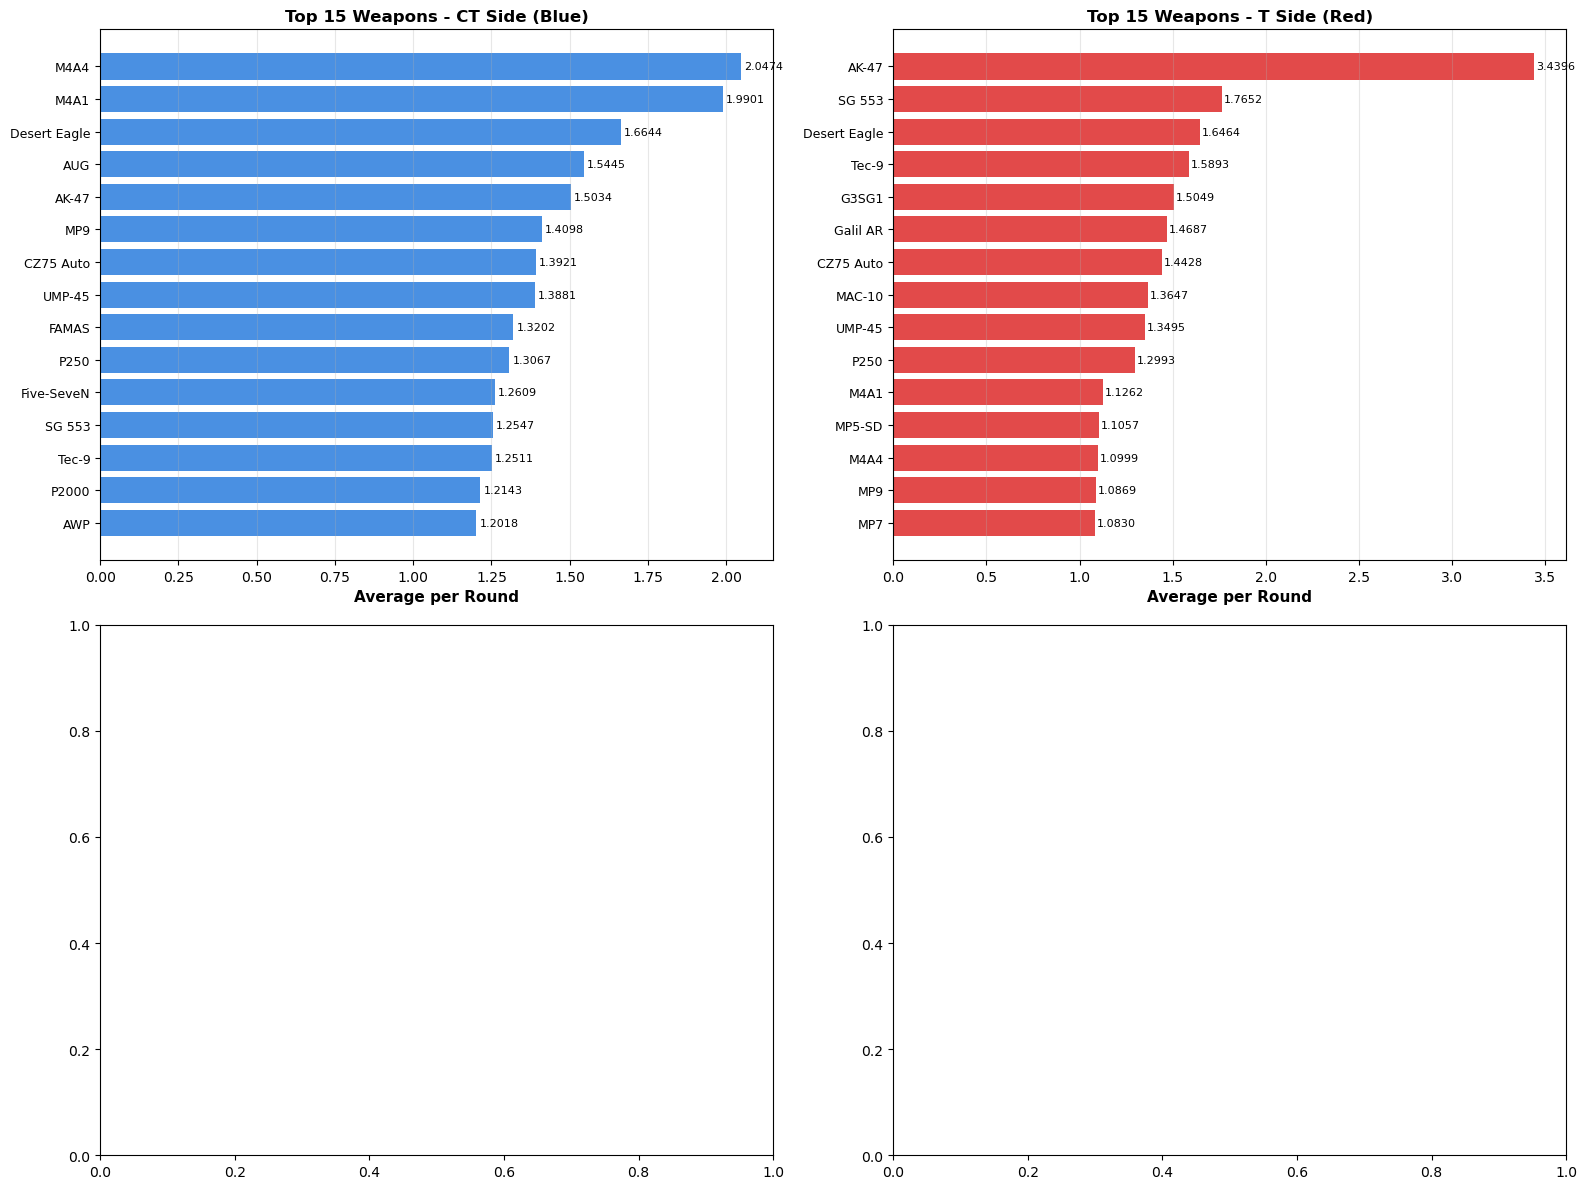

✅ Side comparison visualizations complete!

📊 Summary by Side (Average per Round):
   CT weapons total avg: 46.4985
   T weapons total avg: 47.2164
   CT percentage: 49.62%
   T percentage: 50.38%


In [36]:
# Visualization of weapon statistics grouped by side (CT vs T)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data grouped by side
ct_weapons = weapon_stats_df[(weapon_stats_df['is_ct'] == True) & (weapon_stats_df['equipment_class'] != 6) & (weapon_stats_df['equipment_type'] != 2) & (weapon_stats_df['equipment_type'] != 9)].sort_values('avg_per_round', ascending=False)
t_weapons = weapon_stats_df[(weapon_stats_df['is_ct'] == False) & (weapon_stats_df['equipment_class'] != 6) & (weapon_stats_df['equipment_type'] != 2) & (weapon_stats_df['equipment_type'] != 9)].sort_values('avg_per_round', ascending=False)

# 1. Top 15 CT weapons
ax1 = axes[0, 0]
ct_top_15 = ct_weapons.head(15)
bars1 = ax1.barh(range(len(ct_top_15)), ct_top_15['avg_per_round'], color='#4A90E2')
ax1.set_yticks(range(len(ct_top_15)))
ax1.set_yticklabels([f"{row['equipment_string']}" for _, row in ct_top_15.iterrows()], fontsize=9)
ax1.set_xlabel('Average per Round', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Weapons - CT Side (Blue)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
for i, (idx, row) in enumerate(ct_top_15.iterrows()):
    ax1.text(row['avg_per_round'] + 0.01, i, f"{row['avg_per_round']:.4f}", va='center', fontsize=8)
ax1.grid(axis='x', alpha=0.3)

# 2. Top 15 T weapons
ax2 = axes[0, 1]
t_top_15 = t_weapons.head(15)
bars2 = ax2.barh(range(len(t_top_15)), t_top_15['avg_per_round'], color='#E24A4A')
ax2.set_yticks(range(len(t_top_15)))
ax2.set_yticklabels([f"{row['equipment_string']}" for _, row in t_top_15.iterrows()], fontsize=9)
ax2.set_xlabel('Average per Round', fontsize=11, fontweight='bold')
ax2.set_title('Top 15 Weapons - T Side (Red)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for i, (idx, row) in enumerate(t_top_15.iterrows()):
    ax2.text(row['avg_per_round'] + 0.01, i, f"{row['avg_per_round']:.4f}", va='center', fontsize=8)
ax2.grid(axis='x', alpha=0.3)


plt.tight_layout()
plt.show()

print(f"✅ Side comparison visualizations complete!")
print(f"\n📊 Summary by Side (Average per Round):")
print(f"   CT weapons total avg: {ct_total:.4f}")
print(f"   T weapons total avg: {t_total:.4f}")
print(f"   CT percentage: {100.0 * ct_total / (ct_total + t_total):.2f}%")
print(f"   T percentage: {100.0 * t_total / (ct_total + t_total):.2f}%")

In [20]:
# Query for detailed round outcomes
query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
        hmi.team_1_id,
        hmi.team_2_id,
        hmi.event_id
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8, 11,12,13
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
player_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)
            ELSE 0 END) as ct_player_money,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)  
            ELSE 0 END) as t_player_money
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
previous_round_stats AS (
    SELECT 
        r.id as round_id,
        r.match_id,
        r.round_num,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as ct_prev_kills,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as t_prev_kills,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as ct_prev_assists,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as t_prev_assists,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as ct_prev_deaths,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as t_prev_deaths
    FROM rounds_ed r
    LEFT JOIN rounds_ed r_prev ON r.match_id = r_prev.match_id 
    
        AND r_prev.round_num = r.round_num - 1 
        AND r.round_num > 1
    LEFT JOIN player_round_ed pr_prev ON r_prev.id = pr_prev.round_id AND pr_prev.player_id != 0
    GROUP BY 1,2,3
),
inventory_aggregated AS (
    SELECT 
        ire.team,
        ire.round_id,
        ire.is_ct_t1,
     -- Specific equipment types (listed individually)
        SUM(CASE WHEN ire.equipment_type = 9 THEN 1 ELSE 0 END) as eq_type_9,
        SUM(CASE WHEN ire.equipment_type = 2 THEN 1 ELSE 0 END) as eq_type_2,
        SUM(CASE WHEN ire.equipment_type = 4 THEN 1 ELSE 0 END) as eq_type_4,
        SUM(CASE WHEN ire.equipment_type = 101 THEN 1 ELSE 0 END) as eq_type_101,
        SUM(CASE WHEN ire.equipment_type = 102 THEN 1 ELSE 0 END) as eq_type_102,
        SUM(CASE WHEN ire.equipment_type = 104 THEN 1 ELSE 0 END) as eq_type_104,
        SUM(CASE WHEN ire.equipment_type = 106 THEN 1 ELSE 0 END) as eq_type_106,
        SUM(CASE WHEN ire.equipment_type = 301 THEN 1 ELSE 0 END) as eq_type_301,
        SUM(CASE WHEN ire.equipment_type = 302 THEN 1 ELSE 0 END) as eq_type_302,
        SUM(CASE WHEN ire.equipment_type = 303 THEN 1 ELSE 0 END) as eq_type_303,
        SUM(CASE WHEN ire.equipment_type = 304 THEN 1 ELSE 0 END) as eq_type_304,
        SUM(CASE WHEN ire.equipment_type = 305 THEN 1 ELSE 0 END) as eq_type_305,
        SUM(CASE WHEN ire.equipment_type = 306 THEN 1 ELSE 0 END) as eq_type_306,
        SUM(CASE WHEN ire.equipment_type = 309 THEN 1 ELSE 0 END) as eq_type_309,
        SUM(CASE WHEN ire.equipment_type = 310 THEN 1 ELSE 0 END) as eq_type_310,
        SUM(CASE WHEN ire.equipment_type = 311 THEN 1 ELSE 0 END) as eq_type_311,
        SUM(CASE WHEN ire.equipment_type = 501 THEN 1 ELSE 0 END) as eq_type_501,
        SUM(CASE WHEN ire.equipment_type = 502 THEN 1 ELSE 0 END) as eq_type_502,
        SUM(CASE WHEN ire.equipment_type = 503 THEN 1 ELSE 0 END) as eq_type_503,
        SUM(CASE WHEN ire.equipment_type = 504 THEN 1 ELSE 0 END) as eq_type_504,
        SUM(CASE WHEN ire.equipment_type = 505 THEN 1 ELSE 0 END) as eq_type_505,
        SUM(CASE WHEN ire.equipment_type = 506 THEN 1 ELSE 0 END) as eq_type_506,
        -- Equipment class summations (for types not in the specific list)
        SUM(CASE WHEN ire.equipment_type NOT IN (9, 2, 4, 101, 102, 104, 106, 301, 302, 303, 304, 305, 306, 309, 310, 311, 501, 502, 503, 504, 505, 506) 
                      AND ire.equipment_class = 1 THEN 1 ELSE 0 END) as eq_class_1,
        SUM(CASE WHEN ire.equipment_type NOT IN (9, 2, 4, 101, 102, 104, 106, 301, 302, 303, 304, 305, 306, 309, 310, 311, 501, 502, 503, 504, 505, 506) 
                      AND ire.equipment_class = 2 THEN 1 ELSE 0 END) as eq_class_2,
        SUM(CASE WHEN ire.equipment_type NOT IN (9, 2, 4, 101, 102, 104, 106, 301, 302, 303, 304, 305, 306, 309, 310, 311, 501, 502, 503, 504, 505, 506) 
                      AND ire.equipment_class = 3 THEN 1 ELSE 0 END) as eq_class_3,
        SUM(CASE WHEN ire.equipment_type NOT IN (9, 2, 4, 101, 102, 104, 106, 301, 302, 303, 304, 305, 306, 309, 310, 311, 501, 502, 503, 504, 505, 506) 
                      AND ire.equipment_class = 4 THEN 1 ELSE 0 END) as eq_class_4



        from (select
        pr.team,
        ir.player_round_id,
        ir.round_id, 
        re.is_ct_t1,
        ir.equipment_type,
        ir.equipment_class
        from inventory_round_ed ir
    left JOIN player_round_ed pr ON ir.player_round_id = pr.id
    left join rounds_ed re on ir.round_id = re.id
    WHERE (ir.equipment_class != 5 AND ir.event_type = 1)
    ) as ire
        
       
    
    GROUP BY 1,2,3
),
inventory_by_team AS (
    SELECT 
        round_id,
        -- CT side (is_ct_t1 = TRUE, representing team 1 as CT)
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_9 ELSE 0 END) as ct_eq_type_9,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_9 ELSE 0 END) as t_eq_type_9,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_2 ELSE 0 END) as ct_eq_type_2,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_2 ELSE 0 END) as t_eq_type_2,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_4 ELSE 0 END) as ct_eq_type_4,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_4 ELSE 0 END) as t_eq_type_4,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_101 ELSE 0 END) as ct_eq_type_101,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_101 ELSE 0 END) as t_eq_type_101,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_102 ELSE 0 END) as ct_eq_type_102,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_102 ELSE 0 END) as t_eq_type_102,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_104 ELSE 0 END) as ct_eq_type_104,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_104 ELSE 0 END) as t_eq_type_104,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_106 ELSE 0 END) as ct_eq_type_106,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_106 ELSE 0 END) as t_eq_type_106,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_301 ELSE 0 END) as ct_eq_type_301,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_301 ELSE 0 END) as t_eq_type_301,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_302 ELSE 0 END) as ct_eq_type_302,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_302 ELSE 0 END) as t_eq_type_302,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_303 ELSE 0 END) as ct_eq_type_303,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_303 ELSE 0 END) as t_eq_type_303,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_304 ELSE 0 END) as ct_eq_type_304,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_304 ELSE 0 END) as t_eq_type_304,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_305 ELSE 0 END) as ct_eq_type_305,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_305 ELSE 0 END) as t_eq_type_305,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_306 ELSE 0 END) as ct_eq_type_306,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_306 ELSE 0 END) as t_eq_type_306,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_309 ELSE 0 END) as ct_eq_type_309,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_309 ELSE 0 END) as t_eq_type_309,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_310 ELSE 0 END) as ct_eq_type_310,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_310 ELSE 0 END) as t_eq_type_310,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_311 ELSE 0 END) as ct_eq_type_311,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_311 ELSE 0 END) as t_eq_type_311,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_501 ELSE 0 END) as ct_eq_type_501,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_501 ELSE 0 END) as t_eq_type_501,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_502 ELSE 0 END) as ct_eq_type_502,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_502 ELSE 0 END) as t_eq_type_502,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_503 ELSE 0 END) as ct_eq_type_503,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_503 ELSE 0 END) as t_eq_type_503,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_504 ELSE 0 END) as ct_eq_type_504,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_504 ELSE 0 END) as t_eq_type_504,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_505 ELSE 0 END) as ct_eq_type_505,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_505 ELSE 0 END) as t_eq_type_505,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_type_506 ELSE 0 END) as ct_eq_type_506,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_type_506 ELSE 0 END) as t_eq_type_506,
        -- Equipment class groupings (non-specific types)
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_class_1 ELSE 0 END) as ct_eq_class_1,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_class_1 ELSE 0 END) as t_eq_class_1,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_class_2 ELSE 0 END) as ct_eq_class_2,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_class_2 ELSE 0 END) as t_eq_class_2,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_class_3 ELSE 0 END) as ct_eq_class_3,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_class_3 ELSE 0 END) as t_eq_class_3,
        SUM(CASE WHEN is_ct_t1 = TRUE THEN eq_class_4 ELSE 0 END) as ct_eq_class_4,
        SUM(CASE WHEN is_ct_t1 = FALSE THEN eq_class_4 ELSE 0 END) as t_eq_class_4
    FROM inventory_aggregated as ire
    GROUP BY 1
), 
ranked_data AS (
    SELECT 
        trd.id,
        trd.id_demo_exports,
        trd.round_num,
        trd.team1_winner,
        -- Team 1 metrics
        CAST(het1.rank_during AS INTEGER) as t1_rank,
        -- Team 2 metrics
        CAST(het2.rank_during AS INTEGER) as t2_rank
    FROM round_equipment trd
    LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
    LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
    WHERE het1.rank_during IS NOT NULL 
        AND het2.rank_during IS NOT NULL
)
SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.t_saved_equipment,
    -- All money columns for analysis
    pm.ct_player_money,
    pm.t_player_money,
    rd.t1_rank,
    rd.t2_rank,
    -- Previous round stats
    prs.ct_prev_kills,
    prs.t_prev_kills,
    prs.ct_prev_assists,
    prs.t_prev_assists,
    prs.ct_prev_deaths,
    prs.t_prev_deaths,
    -- Inventory data for CT and T
    ibt.ct_eq_type_9,
    ibt.t_eq_type_9,
    ibt.ct_eq_type_2,
    ibt.t_eq_type_2,
    ibt.ct_eq_type_4,
    ibt.t_eq_type_4,
    ibt.ct_eq_type_101,
    ibt.t_eq_type_101,
    ibt.ct_eq_type_102,
    ibt.t_eq_type_102,
    ibt.ct_eq_type_104,
    ibt.t_eq_type_104,
    ibt.ct_eq_type_106,
    ibt.t_eq_type_106,
    ibt.ct_eq_type_301,
    ibt.t_eq_type_301,
    ibt.ct_eq_type_302,
    ibt.t_eq_type_302,
    ibt.ct_eq_type_303,
    ibt.t_eq_type_303,
    ibt.ct_eq_type_304,
    ibt.t_eq_type_304,
    ibt.ct_eq_type_305,
    ibt.t_eq_type_305,
    ibt.ct_eq_type_306,
    ibt.t_eq_type_306,
    ibt.ct_eq_type_309,
    ibt.t_eq_type_309,
    ibt.ct_eq_type_310,
    ibt.t_eq_type_310,
    ibt.ct_eq_type_311,
    ibt.t_eq_type_311,
    ibt.ct_eq_type_501,
    ibt.t_eq_type_501,
    ibt.ct_eq_type_502,
    ibt.t_eq_type_502,
    ibt.ct_eq_type_503,
    ibt.t_eq_type_503,
    ibt.ct_eq_type_504,
    ibt.t_eq_type_504,
    ibt.ct_eq_type_505,
    ibt.t_eq_type_505,
    ibt.ct_eq_type_506,
    ibt.t_eq_type_506,
    ibt.ct_eq_class_1,
    ibt.t_eq_class_1,
    ibt.ct_eq_class_2,
    ibt.t_eq_class_2,
    ibt.ct_eq_class_3,
    ibt.t_eq_class_3,
    ibt.ct_eq_class_4,
    ibt.t_eq_class_4
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN player_money pm ON re.id = pm.round_id
LEFT JOIN ranked_data rd ON re.id = rd.id
LEFT JOIN previous_round_stats prs ON re.id = prs.round_id
LEFT JOIN inventory_by_team ibt ON re.id = ibt.round_id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
ORDER BY re.match_id, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Recode round end reasons: 1→1, 9→2, 7→3, 8→4
print("🔹 Recoding round end reasons")
original_count = len(detailed_df)
print(f"   Original distribution:")
for old_code in [1, 7, 8, 9]:
    count = (detailed_df['round_end_reason'] == old_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
    1: 1,  # T Win (Target Bombed) - no change
    9: 2,  # T Win (Elimination) - 9 → 2
    7: 3,  # CT Win (Defuse) - 7 → 3
    8: 4,  # CT Win (Elimination) - 8 → 4
})

print(f"   New distribution:")
for new_code in [1, 2, 3, 4]:
    count = (detailed_df['round_end_reason'] == new_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
print()


📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_30292\1724375673.py:348: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 7: 405,067 rounds (15.57%)
      Reason 8: 934,538 rounds (35.92%)
      Reason 9: 854,541 rounds (32.85%)
   New distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 2: 854,541 rounds (32.85%)
      Reason 3: 405,067 rounds (15.57%)
      Reason 4: 934,538 rounds (35.92%)



In [21]:


# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)
reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

before = len(detailed_df)
detailed_df = detailed_df[~filtered_9]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 2,821 rounds where Reason 2 occurred but CT had survivors > 0
   Removed: 2,821 rounds
   Remaining: 2,598,771 rounds

✅ Data quality filtering complete


# The Data Science/ Data Engineering part


In [22]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.datasets import make_classification

import statsmodels.api as sm

test_size_global = 0.3
random_state_global = 42

In [23]:
detailed_df['ct_t_ratio'] = np.log(detailed_df['ct_equipment'] / detailed_df['t_equipment'])
x_r = detailed_df[['ct_t_ratio']]
y = detailed_df['ct_winner']

# Split data
xtr_train, xtr_test, ytr_train, ytr_test = train_test_split(x_r, y, test_size=test_size_global, random_state=random_state_global)
# train dataset
log_model = sm.Logit(ytr_train, sm.add_constant(xtr_train))
result = log_model.fit()
print(result.summary())

# test dataset
yhat = result.predict(sm.add_constant(xtr_test))
prediction = list(map(round, yhat))

cm = confusion_matrix(ytr_test, prediction) 
print ("Confusion Matrix : \n", cm) 
print('Test accuracy = ', accuracy_score(ytr_test, prediction)) 


Optimization terminated successfully.
         Current function value: 0.582460
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              ct_winner   No. Observations:              1819139
Model:                          Logit   Df Residuals:                  1819137
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Jan 2026   Pseudo R-squ.:                  0.1591
Time:                        13:34:02   Log-Likelihood:            -1.0596e+06
converged:                       True   LL-Null:                   -1.2600e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.983      0.326      -0.005       0.002
ct_t_ratio     1.0825      0.

In [24]:
# Create new equipment class features
print("=" * 80)
print("CREATING EQUIPMENT CLASS FEATURES")
print("=" * 80)
print()

# Helper function to check which equipment classes a team has
def get_team_eq_classes(row, is_ct):
    """Get set of equipment classes for CT or T side"""
    classes = set()
    prefix = 'ct_eq_class_' if is_ct else 't_eq_class_'
    for class_num in [1, 2, 3, 4, 5]:
        col_name = f'{prefix}{class_num}'
        if col_name in row.index and row[col_name] > 0:
            classes.add(class_num)
    return classes

# Create new features
detailed_df['ct_eq_classes'] = detailed_df.apply(lambda row: get_team_eq_classes(row, True), axis=1)
detailed_df['t_eq_classes'] = detailed_df.apply(lambda row: get_team_eq_classes(row, False), axis=1)

# Feature 1: Only CT has equipment class 1 (and T doesn't)
detailed_df['only_ct_has_class_1'] = (
    (detailed_df['ct_eq_classes'].apply(lambda x: 1 in x)) & 
    (detailed_df['t_eq_classes'].apply(lambda x: 1 not in x))
).astype(int)

# Feature 2: Only T has equipment class 1 (and CT doesn't)
detailed_df['only_t_has_class_1'] = (
    (detailed_df['t_eq_classes'].apply(lambda x: 1 in x)) & 
    (detailed_df['ct_eq_classes'].apply(lambda x: 1 not in x))
).astype(int)

# Feature 3: Only CT has equipment class 4
detailed_df['only_ct_has_class_4'] = (
    (detailed_df['ct_eq_classes'].apply(lambda x: 4 in x)) & 
    (detailed_df['t_eq_classes'].apply(lambda x: 4 not in x))
).astype(int)

# Feature 4: Only T has equipment class 4
detailed_df['only_t_has_class_4'] = (
    (detailed_df['t_eq_classes'].apply(lambda x: 4 in x)) & 
    (detailed_df['ct_eq_classes'].apply(lambda x: 4 not in x))
).astype(int)

# Feature 5: CT has only classes 1,2,3 (no heavy weapons)
detailed_df['ct_only_light_classes'] = detailed_df['ct_eq_classes'].apply(
    lambda x: (x.issubset({1, 2, 3}) and len(x) > 0)
).astype(int)

# Feature 6: T has only classes 1,2,3 (no heavy weapons)
detailed_df['t_only_light_classes'] = detailed_df['t_eq_classes'].apply(
    lambda x: (x.issubset({1, 2, 3}) and len(x) > 0)
).astype(int)

print("✅ Equipment class features created:")
print(f"   - only_ct_has_class_1: {detailed_df['only_ct_has_class_1'].sum():,} rounds")
print(f"   - only_t_has_class_1: {detailed_df['only_t_has_class_1'].sum():,} rounds")
print(f"   - only_ct_has_class_4: {detailed_df['only_ct_has_class_4'].sum():,} rounds")
print(f"   - only_t_has_class_4: {detailed_df['only_t_has_class_4'].sum():,} rounds")
print(f"   - ct_only_light_classes: {detailed_df['ct_only_light_classes'].sum():,} rounds")
print(f"   - t_only_light_classes: {detailed_df['t_only_light_classes'].sum():,} rounds")
print()

# Regression with Enhanced Features
print("=" * 80)
print("LOGISTIC REGRESSION WITH ENHANCED FEATURES")
print("=" * 80)
print()

# Select features: inventory, equipment class features, and player stats
inventory_features = [col for col in detailed_df.columns if col.startswith('ct_eq_') or col.startswith('t_eq_')]

# Equipment class binary features
class_features = [
    'only_ct_has_class_1', 'only_t_has_class_1',
    'only_ct_has_class_4', 'only_t_has_class_4',
    'ct_only_light_classes', 't_only_light_classes'
]

# Player performance stats (previous round and current round)
player_stat_features = [
    'ct_prev_kills', 't_prev_kills',
    'ct_prev_assists', 't_prev_assists',
    'ct_prev_deaths', 't_prev_deaths'
]

# Combine all features
all_features = inventory_features + class_features + player_stat_features

# Remove any columns that don't exist in the dataframe
all_features = [f for f in all_features if f in detailed_df.columns]

print(f"📊 Selected {len(all_features)} features:")
print(f"   - Inventory features: {len(inventory_features)}")
print(f"   - Equipment class features: {len(class_features)}")
print(f"   - Player stat features: {len(player_stat_features)}")
print()

# Prepare data
X_enhanced = detailed_df[all_features].fillna(0)

# Ensure all columns are numeric (convert object dtype to numeric)
for col in X_enhanced.columns:
    if X_enhanced[col].dtype == 'object':
        X_enhanced[col] = pd.to_numeric(X_enhanced[col], errors='coerce').fillna(0)
    # Ensure numeric columns
    X_enhanced[col] = X_enhanced[col].astype(float)

y = detailed_df['ct_winner'].astype(int)

# Check for any NaN values
print(f"🔹 Data quality check:")
print(f"   Total rows: {len(X_enhanced):,}")
print(f"   Rows with NaN: {X_enhanced.isna().any(axis=1).sum():,}")
nan_cols = X_enhanced.columns[X_enhanced.isna().any()].tolist()
print(f"   NaN columns: {nan_cols if nan_cols else 'None'}")
print(f"   Data types: {X_enhanced.dtypes.unique()}")
print()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=test_size_global, random_state=random_state_global)

# Ensure train and test sets are numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Check for zero variance columns
print("🔹 Checking for multicollinearity issues...")
zero_var_cols = [col for col in X_train.columns if X_train[col].var() == 0]
if zero_var_cols:
    print(f"   Removing {len(zero_var_cols)} zero-variance columns: {zero_var_cols}")
    X_train = X_train.drop(columns=zero_var_cols)
    X_test = X_test.drop(columns=zero_var_cols)
    all_features = [f for f in all_features if f not in zero_var_cols]

# Check correlation matrix for highly correlated features (> 0.95)
correlation_matrix = X_train.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]
if high_corr_features:
    print(f"   Found {len(high_corr_features)} highly correlated features (r > 0.95)")
    print(f"   Removing: {high_corr_features[:5]}...")  # Show first 5
    X_train = X_train.drop(columns=high_corr_features)
    X_test = X_test.drop(columns=high_corr_features)
    all_features = [f for f in all_features if f not in high_corr_features]

print(f"   Remaining features after filtering: {len(X_train.columns)}")
print()

# Train logistic regression model with enhanced features
print("🔹 Training Logistic Regression with enhanced features...")
X_train_const = sm.add_constant(X_train, has_constant='add')
X_test_const = sm.add_constant(X_test, has_constant='add')

# Convert to float to ensure numeric type
X_train_const = X_train_const.astype(float)
X_test_const = X_test_const.astype(float)
y_train_array = np.asarray(y_train, dtype=float)

try:
    enhanced_model = sm.Logit(y_train_array, X_train_const)
    enhanced_result = enhanced_model.fit(disp=0)
except np.linalg.LinAlgError:
    print("   ⚠️  Singular matrix detected. Using regularized logistic regression (L2)...")
    from sklearn.linear_model import LogisticRegression as SklearnLR
    sklearn_model = SklearnLR(max_iter=1000, penalty='l2', solver='lbfgs')
    sklearn_model.fit(X_train, y_train_array.astype(int))
    
    # Create a pseudo statsmodels result object for compatibility
    y_pred_prob = sklearn_model.predict_proba(X_test)[:, 1]
    y_pred = sklearn_model.predict(X_test)
    
    print("   Using sklearn LogisticRegression with L2 regularization")
    print(f"   Training accuracy: {sklearn_model.score(X_train, y_train_array.astype(int)):.4f}")
    print()
    
    # Skip statsmodels summary for sklearn model
    print("=" * 80)
    print("REGULARIZED MODEL (SKLEARN)")
    print("=" * 80)
    print("Using L2 regularization to handle multicollinearity")
    print()

print()
print("=" * 80)
print("ENHANCED MODEL SUMMARY")
print("=" * 80)
print(enhanced_result.summary())
print()

# Predictions and evaluation
y_pred_prob = enhanced_result.predict(X_test_const)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=" * 80)
print("ENHANCED MODEL PERFORMANCE METRICS")
print("=" * 80)
print(f"Confusion Matrix:\n{cm}")
print()
print(f"True Negatives (TN):  {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP):  {tp:,}")
print()
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred):.4f}")
print(f"Recall:     {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:   {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC:    {roc_auc_score(y_test, y_pred_prob):.4f}")
print()

# Feature importance (coefficients)
print("=" * 80)
print("TOP 20 MOST IMPORTANT FEATURES (by coefficient magnitude)")
print("=" * 80)
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': enhanced_result.params[1:].values,
    'Std Error': enhanced_result.bse[1:].values,
    'P-value': enhanced_result.pvalues[1:].values,
    'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' 
                    for p in enhanced_result.pvalues[1:].values]
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.head(20).to_string(index=False))
print()

# Highlight the new equipment class features
print("=" * 80)
print("EQUIPMENT CLASS FEATURES COEFFICIENTS")
print("=" * 80)
class_coefs = coef_df[coef_df['Feature'].isin(class_features)]
print(class_coefs.to_string(index=False))
print()

# Highlight player stat features
print("=" * 80)
print("PLAYER STAT FEATURES COEFFICIENTS")
print("=" * 80)
stat_coefs = coef_df[coef_df['Feature'].isin(player_stat_features)]
print(stat_coefs.to_string(index=False))
print()

print("✅ Enhanced regression analysis complete!")


CREATING EQUIPMENT CLASS FEATURES

✅ Equipment class features created:
   - only_ct_has_class_1: 1,007,391 rounds
   - only_t_has_class_1: 1,003,743 rounds
   - only_ct_has_class_4: 202,183 rounds
   - only_t_has_class_4: 200,389 rounds
   - ct_only_light_classes: 872,953 rounds
   - t_only_light_classes: 870,345 rounds

LOGISTIC REGRESSION WITH ENHANCED FEATURES

📊 Selected 66 features:
   - Inventory features: 54
   - Equipment class features: 6
   - Player stat features: 6

🔹 Data quality check:
   Total rows: 2,598,771
   Rows with NaN: 0
   NaN columns: None
   Data types: [dtype('float64')]

🔹 Checking for multicollinearity issues...
   Removing 2 zero-variance columns: ['ct_eq_classes', 't_eq_classes']
   Found 4 highly correlated features (r > 0.95)
   Removing: ['ct_eq_type_505', 't_eq_type_505', 'ct_prev_deaths', 't_prev_deaths']...
   Remaining features after filtering: 60

🔹 Training Logistic Regression with enhanced features...

ENHANCED MODEL SUMMARY
                     